In [3]:
# 코랩에서 시행시 설치해줘야함.
## 설치 완료 후 상위 메뉴에서 런타임 -> 세션 다시시작 해줘야함.

!pip install numpy==1.26.4
!pip install scipy==1.11.1
!pip install pandas==2.1.4
!pip install scikit-learn==1.4.2
!pip install joblib==1.3.0
!pip install catboost==1.2.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 46.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.11.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.9/301.9 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import sparse, special, stats

# Machine Learning
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import catboost

# Parallel Processing
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

# Data Structure and Iteration
from collections import defaultdict
from itertools import combinations, permutations

# Visualization
import matplotlib.pyplot as plt

# System and Utilities
import os
import re
import random
import warnings
import contextlib
import itertools
from typing import List, Set, Dict, Tuple, Optional
import json

# 데이터 불러오기 (VIQ 데이터)

In [2]:
# VIQ
url = 'https://raw.githubusercontent.com/novicedata/Grove_CAT/refs/heads/main/data/VIQT_data.csv'
data = pd.read_csv(url, sep = '\t')

In [3]:
data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,S26,S27,S28,S29,S30,education,urban,gender,engnat,age
0,24,3,10,24,9,-1,5,10,18,10,...,2,5,2,3,2,3,3,2,1,54
1,24,3,10,3,9,12,17,10,20,10,...,3,1,4,5,5,2,3,2,1,16
2,24,3,10,5,9,9,10,10,17,10,...,4,5,5,5,1,4,2,2,1,32
3,24,3,10,5,9,9,17,10,0,10,...,1,1,5,5,5,4,3,1,2,24
4,24,3,10,5,9,9,17,10,17,10,...,3,3,4,4,3,3,3,1,1,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,24,3,10,5,9,9,6,10,17,10,...,3,4,4,3,3,4,3,1,1,51
12169,24,3,10,5,9,9,17,10,17,10,...,1,5,2,3,5,2,3,1,1,33
12170,24,3,10,24,9,9,17,10,-1,10,...,2,4,3,3,4,3,2,2,1,40
12171,24,18,-1,-1,17,-1,3,18,9,0,...,2,2,5,5,3,3,3,1,2,28


# 데이터 정제

gender, age, NaN 처리

문항 칼럼만 남기고 code book에 있는 대로 정답키를 생성하여 적용, 점수 또한 code book에 있는 그대로 적용한 후 합격, 불합격자를 상위 30%를 기점으로 분류

In [4]:
#VIQ
print(f'raw : {data.shape}')

# gender가 3 또는 0인 행 제거
data.drop(data[(data['gender'] == 3) | (data['gender'] == 0)].index, inplace=True)

# age가 14세 미만 또는 80세 초과인 행 제거
data.drop(data[(data['age'] < 14) | (data['age'] > 80)].index, inplace=True)
print(f'After filtering gender and age: {data.shape}')

# NaN 행 제거
data.dropna(inplace=True)
print(f'After dropping NaN: {data.shape}')

# 필요한 컬럼만 남김 (Q1 ~ Q45)
data = data.iloc[:, 0:45]

# 정답 키 생성
answers = {
    'Q1': 24, 'Q2': 3, 'Q3': 10, 'Q4': 5, 'Q5': 9,
    'Q6': 9, 'Q7': 17, 'Q8': 10, 'Q9': 17, 'Q10': 10,
    'Q11': 5, 'Q12': 17, 'Q13': 9, 'Q14': 5, 'Q15': 18,
    'Q16': 18, 'Q17': 3, 'Q18': 12, 'Q19': 18, 'Q20': 18,
    'Q21': 3, 'Q22': 18, 'Q23': 6, 'Q24': 12, 'Q25': 17,
    'Q26': 10, 'Q27': 10, 'Q28': 9, 'Q29': 9, 'Q30': 3,
    'Q31': 6, 'Q32': 10, 'Q33': 17, 'Q34': 3, 'Q35': 17,
    'Q36': 24, 'Q37': 17, 'Q38': 5,
    'Q39': 5, 'Q40': 24, 'Q41': 5, 'Q42': 5, 'Q43': 12,
    'Q44': 10, 'Q45': 9
}

# 문제별 정답과 일치 여부를 1과 0으로 변환
for q, correct_answer in answers.items():
    data[q] = (data[q] == correct_answer).astype(int)

# score_right와 score_wrong 계산
data['score_right'] = data.iloc[:, :45].sum(axis=1)  # 맞춘 개수 (1의 합)
data['score_wrong'] = 45 - data['score_right']      # 틀린 개수 (전체 45개 중에서 맞춘 개수를 뺀 값)

# score_full 계산
data['score_full'] = data['score_right'] - 0.35 * data['score_wrong']
print(data['score_full'].quantile(0.70))

# score_full이 상위 30%인지 여부를 이진 변수로 변환
data['score_full'] = (data['score_full'] >= data['score_full'].quantile(0.70)).astype(int)

# X와 y 분리
X = data.iloc[:, 0:45]
y = data['score_full']

# 결과 확인
print(X.head())
print(y.head())


raw : (12173, 131)
After filtering gender and age: (11525, 131)
After dropping NaN: (11502, 131)
36.9
   Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q36  Q37  Q38  Q39  Q40  Q41  \
0   1   1   1   0   1   0   0   1   0    1  ...    0    0    0    1    0    0   
1   1   1   1   0   1   0   1   1   0    1  ...    0    1    0    0    0    1   
2   1   1   1   1   1   1   0   1   1    1  ...    1    1    0    1    0    1   
3   1   1   1   1   1   1   1   1   0    1  ...    0    0    1    0    0    1   
4   1   1   1   1   1   1   1   1   1    1  ...    1    1    0    1    1    1   

   Q42  Q43  Q44  Q45  
0    0    0    1    1  
1    1    0    0    1  
2    0    0    0    0  
3    0    0    0    1  
4    1    0    0    1  

[5 rows x 45 columns]
0    0
1    0
2    0
3    0
4    1
Name: score_full, dtype: int64


In [5]:
y.value_counts()

,count
score_full,
0,7699
1,3803


# CATBoost 적합

In [6]:
def train_catboost(X_train, y_train, X_test, y_test,
                   max_depth=3,
                   n_estimators=100,
                   learning_rate=1,
                   subsample=0.5,
                   min_child_samples=1,
                   random_state=42,
                   auto_class_weights=None):
    """
    주어진 파라미터로 CatBoost 모델을 학습시키는 함수입니다.
    :param X_train: 학습 데이터
    :param y_train: 학습 데이터의 레이블
    :param X_test: 테스트 데이터
    :param y_test: 테스트 데이터의 레이블
    :param max_depth: 트리의 최대 깊이 (default: 3)
    :param n_estimators: 생성할 트리의 수 (default: 100)
    :param learning_rate: 학습률 (default: 1)
    :param colsample_bylevel: 각 레벨에서 사용할 특성의 비율 (default: 0.5)
    :param subsample: 각 트리가 사용할 데이터의 비율 (default: 0.5)
    :param min_child_samples: 리프 노드의 최소 샘플 수 (default: 1)
    :param random_state: 랜덤 시드 (default: 42)
    :param auto_class_weights: 클래스 가중치 자동 설정 (default: None)
    :return: 학습된 모델과 파라미터
    """
    # 모델 파라미터 설정
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': learning_rate,
        'depth': max_depth,
        'subsample': subsample,
        'grow_policy' : 'Lossguide',
        'random_seed': random_state,
        'iterations': n_estimators,
        'verbose': False,
        'thread_count': -1,
        'auto_class_weights': auto_class_weights
    }

    # Pool 생성
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)

    # 모델 생성 및 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=test_pool,
              verbose=False)

    # 학습 데이터에 대한 예측 및 AUC 계산
    y_pred_train = model.predict_proba(train_pool)[:, 1]
    train_auc = roc_auc_score(y_train, y_pred_train)
    print(f"Final model AUC on train data: {train_auc}")

    # 테스트 데이터에 대한 예측 및 AUC 계산
    y_pred_test = model.predict_proba(test_pool)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_test)
    print(f"Final model AUC on test data: {test_auc}")

    return model, params


# Grove 코드

### 초기화 및 캐싱 메커니즘:

'__init__' 함수에서 세 가지 캐시 딕셔너리를 초기화:

1. _path_cache: 트리 경로 정보를 저장

2. _feature_cache: 각 트리가 사용하는 특성(feature) 집합을 저장

3. _prediction_cache: 트리별 예측값을 저장




### 트리 구조 분석:

get_tree_paths: 트리의 모든 가능한 경로와 각 경로에서 사용하는 특성들을 추출.

extract_features_from_node: 재귀적으로 트리 노드를 순회하며 사용된 특성들을 추출.

extract_tree_features: CatBoost 모델을 JSON 형식으로 저장하고 각 트리별로 사용된 모든 특성을 분석.

get_path_features_from_node: 특정 노드에서 시작하여 가능한 모든 경로의 특성 집합을 추출.


### 메모리 최적화:

optimize_numeric_dtypes: 수치형 데이터의 데이터 타입을 최적화하여 메모리 사용량을 줄임.

_temporary_pool: 컨텍스트 매니저를 통해 메모리를 효율적으로 관리.


### 트리 조합 분석:

calculate_item_range: 주어진 트리 조합에서 사용자가 받게 될 최소/최대 문항 수를 계산.

find_optimal_tree_groups: 지정된 트리 개수 범위를 만족하고 필수 특성을 포함하는 모든 가능한 트리 조합을 찾음.

get_tree_predictions: 메모리 효율적인 방식으로 특정 트리의 예측값을 계산.


### 병렬 처리 및 결과 생성:

process_tree_groups_batch: 배치 단위로 트리 그룹을 처리하여 성능 지표를 계산.

create_results_dataframe: 분석 결과를 정리하여 데이터프레임으로 변환.


### 메인 분석 프로세스 (analyze 함수):

입력 데이터와 매개변수 검증

트리별 특성 추출

트리별 예측값 계산

유효한 트리 조합 탐색

병렬 처리를 통한 조합별 성능 평가

AUC 기준 상위 조합 필터링

최소/최대 문항 수 계산

결과 정리 및 반환


### 예측 기능 (predict 함수):

선택된 트리 조합만을 사용하여 학습 및 테스트 데이터에 대한 예측을 수행.

각 트리의 예측값을 합산한 후 시그모이드 함수를 적용하여 확률값으로 변환.

In [7]:
class Grove:
    def __init__(self):
        # 캐시 초기화: 트리 경로, feature, 예측값에 대한 캐시를 각각 딕셔너리로 생성
        self._path_cache: Dict[int, List[Dict]] = {}  # 트리 경로 캐시
        self._feature_cache: Dict[int, Set[str]] = {}  # feature 캐시
        self._prediction_cache: Dict[Tuple[int, int], np.ndarray] = {}  # 예측값 캐시

    def get_tree_paths(self, tree_data: Dict, splits: List[Dict], leaf_values: List[float], tree_idx: Optional[int] = None) -> List[Dict]:
        """
        주어진 트리 데이터를 바탕으로 모든 가능한 경로를 추출합니다.
        - 각 경로에서 만나게 되는 feature들을 추출하고, 리프 노드에서의 값을 기록합니다.
        - 캐시를 사용하여 동일한 트리에 대해 중복된 계산을 피합니다.
        """
        # 이미 경로가 캐시되어 있는 경우 즉시 반환하여 계산을 생략
        if tree_idx is not None and tree_idx in self._path_cache:
            return self._path_cache[tree_idx]

        paths = []  # 결과를 저장할 리스트. 각 요소는 하나의 경로에 해당

        def traverse_tree(node_idx=0, current_features=None):
            if current_features is None:
                current_features = set()  # 현재 경로에서 만난 feature 인덱스를 저장

            # 현재 노드가 리프 노드이거나 splits 범위를 벗어난 경우
            if node_idx >= len(splits) or "leaf_values" in splits[node_idx]:
                # 리프 노드의 값을 추출 (노드 안에 직접 있거나 외부 leaf_values에서 추출)
                leaf_value = splits[node_idx].get("leaf_values", leaf_values[node_idx - len(splits)])
                # 경로에 사용된 feature들과 리프 값을 저장
                paths.append({
                    'features': current_features.copy(),  # 집합을 복사하여 저장
                    'value': leaf_value
                })
                return  # 리프 노드이므로 재귀 종료

            # 내부 노드일 경우 split 정보 추출
            split = splits[node_idx]
            if "float_feature_index" in split:
                # 현재 노드에서 사용된 feature index를 집합에 추가
                current_features.add(split["float_feature_index"])

            # 자식 노드 인덱스를 추출 (명시적 인덱스가 없으면 이진트리 규칙 사용)
            left_idx = split.get("left_child_index", 2 * node_idx + 1)
            right_idx = split.get("right_child_index", 2 * node_idx + 2)

            # 왼쪽 자식이 존재하면 재귀적으로 탐색 (feature 집합 복사)
            if left_idx < len(splits):
                traverse_tree(left_idx, current_features.copy())

            # 오른쪽 자식이 존재하면 재귀적으로 탐색
            if right_idx < len(splits):
                traverse_tree(right_idx, current_features.copy())

        # 트리 순회를 루트 노드(0번 인덱스)부터 시작
        traverse_tree()

        # 트리 인덱스가 주어졌다면 캐시에 결과 저장
        if tree_idx is not None:
            self._path_cache[tree_idx] = paths

        return paths  # 경로 리스트 반환


    def extract_features_from_node(self, node):
        """
        트리 노드를 재귀적으로 순회하면서 feature를 추출합니다.
        - 각 노드가 split을 가지고 있으면 해당 feature를 추출하고,
        - 왼쪽과 오른쪽 자식 노드에서도 동일한 작업을 수행합니다.
        """
        features = set()  # 최종적으로 반환할 feature 인덱스를 저장할 집합

        # 현재 노드가 split 조건을 가지고 있는 경우
        if 'split' in node:
            split = node['split']  # split 정보 추출
            if 'float_feature_index' in split:
                # split에서 사용된 float feature 인덱스를 추가
                features.add(split['float_feature_index'])

        # 왼쪽 자식 노드가 존재하고, 그것이 딕셔너리 형식일 경우
        if 'left' in node and isinstance(node['left'], dict):
            # 왼쪽 서브트리에서 추출한 feature들을 병합
            features.update(self.extract_features_from_node(node['left']))

        # 오른쪽 자식 노드가 존재하고, 그것이 딕셔너리 형식일 경우
        if 'right' in node and isinstance(node['right'], dict):
            # 오른쪽 서브트리에서 추출한 feature들을 병합
            features.update(self.extract_features_from_node(node['right']))

        return features  # 전체 서브트리에서 추출된 feature 인덱스 집합 반환


    def extract_tree_features(self, model: CatBoostClassifier or CatBoostRegressor, tree_idx: Optional[int] = None):
        """
        주어진 CatBoost 모델에서 트리별로 사용된 모든 feature를 추출합니다.
        - 모델을 JSON 형식으로 저장하고 이를 로드하여 트리 구조를 파싱합니다.
        - 캐시를 사용하여 동일한 트리에 대해 중복된 작업을 피합니다.
        """
        # 특정 트리 인덱스가 주어졌고, 해당 트리의 feature 정보가 캐시에 존재하면 즉시 반환
        if tree_idx is not None and tree_idx in self._feature_cache:
            return self._feature_cache[tree_idx]

        # 모델을 임시 JSON 파일로 저장 (CatBoost는 JSON 포맷으로 트리 구조 제공)
        temp_json_file = "temp_model.json"
        model.save_model(temp_json_file, format="json")

        # 저장한 JSON 파일을 열고 전체 모델 구조를 파싱
        with open(temp_json_file, "r") as f:
            model_json = json.load(f)

        trees = model_json["trees"]  # 트리 리스트를 추출

        if tree_idx is not None:
            # 단일 트리만 처리하는 경우
            tree_data = trees[tree_idx]  # 해당 트리 데이터 추출
            features = self.extract_features_from_node(tree_data)  # 해당 트리에서 feature 추출
            self._feature_cache[tree_idx] = features  # 캐시에 저장
            return features  # 추출된 feature 반환
        else:
            # 전체 트리에 대해 반복적으로 feature 추출 수행
            features = []
            for i, tree_data in enumerate(trees):
                # 각 트리에 대해 재귀 호출하여 feature 추출 (캐시가 자동 적용됨)
                features.append(self.extract_tree_features(model, i))
            return features  # 전체 트리에 대한 feature 리스트 반환


    def get_path_features_from_node(self, node, current_features=None):
        """
        주어진 노드에서 모든 가능한 경로의 feature 집합을 추출합니다.
        - 재귀적으로 왼쪽과 오른쪽 자식 노드를 순회하며 경로를 기록합니다.
        """
        if current_features is None:
            current_features = set()  # 현재까지의 경로에서 만난 feature들을 저장할 집합 초기화

        # 리프 노드에 도달한 경우
        if 'value' in node:
            return [current_features.copy()]  # 해당 경로에서의 feature 집합을 반환 (리스트에 담아서 반환)

        # 현재 노드가 split을 가지고 있으면 feature 인덱스를 추가
        if 'split' in node:
            current_features.add(node['split']['float_feature_index'])

        paths = []  # 모든 경로의 feature 집합을 저장할 리스트

        # 왼쪽 자식 노드가 존재하면 재귀적으로 탐색
        if 'left' in node:
            left_paths = self.get_path_features_from_node(node['left'], current_features.copy())
            paths.extend(left_paths)  # 왼쪽에서 얻은 경로들을 리스트에 추가

        # 오른쪽 자식 노드가 존재하면 재귀적으로 탐색
        if 'right' in node:
            right_paths = self.get_path_features_from_node(node['right'], current_features.copy())
            paths.extend(right_paths)  # 오른쪽에서 얻은 경로들을 리스트에 추가

        return paths  # 모든 리프 노드 경로에서의 feature 집합 리스트를 반환


    def calculate_item_range(self, model, tree_indices):
        """
        주어진 트리 인덱스들에 대해 최소/최대 문항 수를 계산합니다.
        - 트리의 가능한 경로들을 feature set으로 변환한 뒤, 모든 경로 조합을 계산하여 문항 수를 측정합니다.
        """
        # 각 트리의 가능한 경로들을 feature 집합으로 변환하여 저장할 리스트
        tree_feature_sets = []

        # 모델 구조를 JSON 형식으로 임시 파일에 저장
        temp_json_file = "temp_model.json"
        model.save_model(temp_json_file, format="json")

        # 저장한 JSON 파일을 열어서 모델 구조를 로드
        with open(temp_json_file, "r") as f:
            model_json = json.load(f)

        # 트리 정보는 "trees" 키에 저장되어 있음
        trees = model_json["trees"]

        # 각 트리 인덱스에 대해 가능한 경로별 feature 집합을 추출
        for tree_idx in tree_indices:
            tree_data = trees[tree_idx]  # 해당 트리 구조 가져오기
            path_feature_sets = self.get_path_features_from_node(tree_data)  # 모든 경로별 feature set 추출
            tree_feature_sets.append(path_feature_sets)  # 트리별 리스트에 저장

        # 최소/최대 문항 수 초기값 설정
        min_items = float('inf')  # 최소값을 비교 위해 무한대로 시작
        max_items = 0             # 최대값은 0부터 시작

        # 각 트리에서 가능한 모든 경로 조합(product)을 생성
        for path_combination in itertools.product(*tree_feature_sets):
            total_features = set().union(*path_combination)  # 경로 조합에서 등장한 모든 feature들의 합집합
            num_features = len(total_features)  # 사용된 feature의 개수 (문항 수)

            # 현재 경로 조합에서의 문항 수로 최소/최대 갱신
            min_items = min(min_items, num_features)
            max_items = max(max_items, num_features)

        # 최소 문항 수가 여전히 무한대면 문항 없음 → 0 반환
        return min_items if min_items != float('inf') else 0, max_items


    def find_optimal_threshold(self, y_true, y_pred):
        """
        예측 확률에 대해 최적의 임계값을 찾습니다.
        - ROC curve를 통해 최적의 임계값을 계산합니다.
        """
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        optimal_idx = np.argmax(tpr - fpr)  # TPR과 FPR의 차이가 최대가 되는 지점에서 최적의 임계값을 선택
        return thresholds[optimal_idx]

    @contextlib.contextmanager
    def _temporary_pool(self, pool):
        """
        CatBoost Pool 객체를 메모리 효율적으로 사용하기 위한 컨텍스트 매니저
        사용 후 자동 삭제 처리
        """
        try:
            yield pool
        finally:
            del pool

    @staticmethod
    def optimize_numeric_dtypes(arr):
        """
        배열의 데이터 타입을 최적화하여 메모리 효율을 개선합니다.
        - 각 숫자형 배열의 최적의 데이터 타입을 자동으로 선택합니다.
        """
        # 리스트나 튜플로 들어온 경우 NumPy 배열로 변환
        if isinstance(arr, (list, tuple)):
            arr = np.array(arr)

        # 정수형 배열인 경우
        if np.issubdtype(arr.dtype, np.integer):
            min_val, max_val = arr.min(), arr.max()  # 최소값과 최대값 계산

            if min_val >= 0:
                # unsigned int로 다운캐스팅 시도
                if max_val <= np.iinfo(np.uint8).max:
                    return arr.astype(np.uint8)  # 가장 작은 unsigned 정수
                elif max_val <= np.iinfo(np.uint16).max:
                    return arr.astype(np.uint16)  # 그 다음 크기의 unsigned 정수
            else:
                # signed int로 다운캐스팅 시도
                if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                    return arr.astype(np.int8)  # 가장 작은 signed 정수
                elif min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max:
                    return arr.astype(np.int16)  # 그 다음 크기의 signed 정수

        # 부동소수점형 배열인 경우
        elif np.issubdtype(arr.dtype, np.floating):
            # float64 값을 float32로 변환해도 값 손실이 없을 경우 다운캐스팅
            if np.allclose(arr, arr.astype(np.float32)):
                return arr.astype(np.float32)

        # 다운캐스팅이 불가능한 경우 원래 배열을 그대로 반환
        return arr

    def get_tree_predictions(self, model, pool, tree_idx, chunk_size=1000):
        """
        주어진 트리 인덱스에 대해 예측값을 계산합니다.
        - 예측값을 메모리 효율적으로 계산하기 위해, chunk 단위로 계산합니다.
        Args:
            model: 학습된 CatBoost 모델
            pool: CatBoost Pool 객체
            tree_idx: 예측에 사용할 트리 인덱스
            chunk_size: 메모리 절약을 위한 청크 크기
        Returns:
            예측값 numpy 배열
        """
        cache_key = (id(model), tree_idx)  # 캐시에서 예측값을 찾기 위한 고유 키 생성 (모델 객체 ID + 트리 번호)

        # 캐시에 해당 트리의 예측값이 존재하면 즉시 반환
        if cache_key in self._prediction_cache:
            return self._prediction_cache[cache_key]

        n_samples = pool.num_row()  # 전체 샘플 수
        predictions = np.zeros(n_samples, dtype=np.float32)  # 예측값을 저장할 배열 초기화

        # 데이터를 chunk 단위로 나누어 반복 처리
        for chunk_start in range(0, n_samples, chunk_size):
            chunk_end = min(chunk_start + chunk_size, n_samples)  # 청크 끝 인덱스 계산
            chunk_indices = np.arange(chunk_start, chunk_end)  # 현재 청크의 샘플 인덱스 범위

            # 현재 청크에 대한 Pool 객체 생성 및 예측 수행
            with self._temporary_pool(pool.slice(chunk_indices)) as chunk_pool:
                chunk_predictions = model.predict(
                    chunk_pool,  # 청크 데이터
                    prediction_type="RawFormulaVal",  # 로짓 값 그대로 예측
                    ntree_start=tree_idx,             # 특정 트리부터 시작
                    ntree_end=tree_idx + 1            # 해당 트리까지만 사용
                )
                predictions[chunk_start:chunk_end] = chunk_predictions  # 결과 저장

        # 계산된 결과를 캐시에 저장하여 이후 재사용 가능하게 함
        self._prediction_cache[cache_key] = predictions
        return predictions  # 전체 샘플에 대한 해당 트리의 raw 예측값 반환


    def find_optimal_tree_groups(self, tree_features, min_num_trees, max_num_trees, required_features=None):
        """
        트리 개수 범위를 만족하고 필수 feature를 포함하는 모든 가능한 트리 조합을 찾습니다.

        Args:
            tree_features: 각 트리별로 사용된 feature들의 집합이 들어있는 리스트
            min_num_trees: 트리 조합의 최소 개수
            max_num_trees: 트리 조합의 최대 개수
            required_features: 포함되어야 할 필수 feature들의 집합 (선택적)

        Returns:
            조건을 만족하는 트리 인덱스 조합 리스트
        """
        num_trees = len(tree_features)  # 전체 트리 개수
        results = []  # 조건을 만족하는 트리 조합을 저장할 리스트

        # 필수 feature가 주어진 경우 집합 형태로 변환, 없으면 빈 집합으로 처리
        required_features = set(required_features) if required_features else set()

        # 트리 개수가 min~max 범위 내에 있을 때 가능한 모든 조합 탐색
        for num_trees_in_group in range(min_num_trees, min(max_num_trees + 1, num_trees + 1)):
            # 해당 개수의 트리 조합 생성 (예: 3개짜리, 4개짜리 조합 등)
            for trees in itertools.combinations(range(num_trees), num_trees_in_group):
                # 선택된 트리들의 feature 집합을 모두 합침 (중복 제거된 union)
                combined_features = set().union(*[tree_features[tree_idx] for tree_idx in trees])

                # 필수 feature 조건을 만족하는 경우에만 결과 리스트에 추가
                if not required_features or required_features.issubset(combined_features):
                    results.append(list(trees))  # 튜플 대신 리스트 형태로 저장

        return results  # 조건을 만족하는 트리 인덱스 조합 리스트 반환


    def process_tree_groups_batch(self, combinations_batch, predictions_by_tree, y, tree_features):
        """
        배치 단위로 트리 그룹을 처리하여 예측값을 계산하고 성능 메트릭을 평가합니다.

        Args:
            combinations_batch: 평가할 트리 조합들의 리스트 (ex: [[0, 2, 4], [1, 3, 5]] 등)
            predictions_by_tree: 각 트리에 대한 예측값 배열 (shape: [n_trees, n_samples])
            y: 실제 타깃 레이블 벡터
            tree_features: 트리별로 사용된 feature 집합 리스트

        Returns:
            트리 조합별 성능 및 특성 정보를 포함한 딕셔너리 리스트
        """
        results = []  # 결과를 저장할 리스트

        for group in combinations_batch:
            # 선택된 트리 그룹의 예측값을 합산하여 앙상블 예측값 계산 (로짓 합)
            predictions_sum = np.sum([predictions_by_tree[tree] for tree in group], axis=0)

            # 시그모이드를 적용하여 확률로 변환 (이진 분류 기준)
            predictions = 1 / (1 + np.exp(-predictions_sum))

            # AUC 점수 계산 (ROC-AUC)
            auc = roc_auc_score(y, predictions)

            # ROC 곡선을 기반으로 최적 임계값 계산
            optimal_threshold = self.find_optimal_threshold(y, predictions)

            # 트리 그룹에서 사용된 feature 목록 수집
            tree_feature_sets = [tree_features[tree] for tree in group]
            all_features = set().union(*tree_feature_sets)  # 전체 feature의 합집합

            # 각 feature가 몇 개의 트리에서 사용되었는지 카운트
            feature_count = {}
            for feature_set in tree_feature_sets:
                for feature in feature_set:
                    feature_count[feature] = feature_count.get(feature, 0) + 1

            # 두 개 이상의 트리에서 중복 사용된 feature
            overlapping_features = {f for f, count in feature_count.items() if count > 1}

            # 한 개의 트리에서만 사용된 독립 feature
            independent_features = {f for f, count in feature_count.items() if count == 1}

            # 결과 저장: 그룹 구성, AUC, 임계값, feature 정보 등
            results.append({
                'groups': [group],  # 트리 인덱스 리스트
                'auc': auc,  # ROC-AUC 점수
                'optimal_threshold': float(optimal_threshold),  # float으로 캐스팅
                'overlapping_items': len(overlapping_features),  # 중복된 feature 수
                'independent_items': len(independent_features),  # 독립된 feature 수
                'features': [all_features],  # 전체 feature 집합
            })

        return results  # 평가 결과 리스트 반환


    def create_results_dataframe(self, results, model, n_jobs=-1):
        """
        트리 개수 순서대로 처리하여 캐시를 효율적으로 활용하고,
        최종적으로 분석 결과를 DataFrame 형태로 생성합니다.

        Args:
            results: 트리 그룹별 평가 결과 리스트 (dict 형태)
            model: CatBoost 모델 (현재는 사용하지 않지만 구조상 포함됨)
            n_jobs: 병렬 처리 시 사용할 스레드 수 (미사용 시 전체 코어 사용)

        Returns:
            평가 결과를 정리한 pandas DataFrame
        """
        print(f"Processing {len(results)} results...")

        # 청크 단위로 나누어 처리 (메모리 및 출력 최적화 목적)
        chunk_size = 10
        result_chunks = [results[i:i + chunk_size] for i in range(0, len(results), chunk_size)]

        df_chunks = []  # 청크별 DataFrame 저장용 리스트

        for chunk_idx, chunk in enumerate(result_chunks):
            # 하나의 청크를 DataFrame으로 변환
            chunk_df = pd.DataFrame([{
                'Model Performance': round(result['auc'], 4),  # ROC-AUC 점수
                'Optimal Threshold': result['optimal_threshold'],  # 최적 임계값
                'Tree Count': len(result['groups'][0]),  # 사용된 트리 개수
                'Tree Indices': result['groups'][0],  # 트리 인덱스 조합
                'Item List': sorted(list(result['features'][0])),  # 사용된 문항(feature) 리스트
                'Total Items': len(result['features'][0]),  # 전체 문항 수
                'Shared Items': result['overlapping_items'],  # 중복 문항 수
                'Unique Items': result['independent_items'],  # 고유 문항 수
                'Min Items/Person': result['min_items'],  # 수험자 기준 최소 문항 수
                'Max Items/Person': result['max_items'],  # 수험자 기준 최대 문항 수
            } for result in chunk])

            df_chunks.append(chunk_df)

            # 일정 간격마다 진행 상황 출력
            if (chunk_idx + 1) % 5 == 0:
                print(f"Completed {chunk_idx + 1} chunks out of {len(result_chunks)}")

        # 모든 청크를 하나의 DataFrame으로 통합
        initial_df = pd.concat(df_chunks, ignore_index=True)
        del df_chunks  # 메모리 확보

        print(f"Initial combinations: {len(initial_df)}")

        # 중복 제거:
        # 동일한 Item List 조합이 있을 경우, AUC가 가장 높은 결과만 선택
        initial_df['items_tuple'] = initial_df['Item List'].apply(tuple)  # 리스트를 튜플로 변환하여 groupby 가능하게 함
        final_max_indices = initial_df.groupby('items_tuple')['Model Performance'].idxmax()  # AUC 기준 최고 점수 인덱스 추출
        unique_df = initial_df.loc[final_max_indices].copy()  # 해당 인덱스만 남기기
        del initial_df

        print(f"After removing duplicates: {len(unique_df)}")

        # Tree Count 기준으로 정렬
        unique_df = unique_df.sort_values('Tree Count')
        unique_df = unique_df.drop('items_tuple', axis=1)  # 중복 판별용 컬럼 제거

        # 컬럼 순서를 재정렬
        column_order = [
            'Model Performance', 'Optimal Threshold', 'Tree Count',
            'Tree Indices', 'Item List', 'Total Items',
            'Shared Items', 'Unique Items',
            'Min Items/Person', 'Max Items/Person'
        ]
        results_df = unique_df[column_order]

        # 성능 기준으로 정렬 (높은 AUC 순서)
        results_df = results_df.sort_values('Model Performance', ascending=False).reset_index(drop=True)

        # float64 컬럼을 float32로 다운캐스팅하여 메모리 최적화
        for col in results_df.columns:
            if results_df[col].dtype == 'float64':
                results_df[col] = results_df[col].astype('float32')

        print(f"Processing completed. Found {len(results_df)} unique combinations.")
        return results_df  # 최종 결과 DataFrame 반환



    def analyze(self, param, X, y, model, tree_range, percentile=100, required_features=None, n_jobs=-1):
        """
        메인 분석 함수
        주어진 모델을 바탕으로 최적 트리 조합을 찾고 성능을 평가합니다.

        Args:
            param: CatBoost 모델 파라미터 (사용하지 않지만 포맷 유지용)
            X: 입력 데이터 (numpy array 또는 DataFrame)
            y: 타깃 레이블
            model: 학습된 CatBoost 모델
            tree_range: 탐색할 트리 수 범위 (예: (3, 5))
            percentile: 상위 몇 % 결과만 필터링할지 지정
            required_features: 반드시 포함되어야 하는 feature 리스트 (optional)
            n_jobs: 사용할 병렬 처리 스레드 수

        Returns:
            평가 결과를 정리한 pandas DataFrame
        """
        print("Initializing analysis...")

        # 필수 feature가 지정된 경우, 실제 feature와 비교하여 누락 여부 확인
        if required_features and isinstance(X, pd.DataFrame):
            print(f"Required features: {required_features}")
            missing_features = set(required_features) - set(X.columns)
            if missing_features:
                raise ValueError(f"Required features not found in data: {missing_features}")

        # 모델 트리 수 확인 및 범위 검증
        num_trees = model.tree_count_
        print(f"Number of trees: {num_trees}")

        min_trees, max_trees = tree_range
        if min_trees < 1:
            raise ValueError("Minimum number of trees must be at least 1")
        if max_trees > num_trees:
            raise ValueError(f"Maximum number of trees cannot exceed total trees ({num_trees})")
        if min_trees > max_trees:
            raise ValueError("Minimum number of trees cannot be greater than maximum")

        # 데이터 전처리 함수 정의
        def prepare_data(X):
            if isinstance(X, pd.DataFrame):
                feature_names = X.columns.tolist()
                X_numpy = np.column_stack([
                    self.optimize_numeric_dtypes(X[col].values)
                    for col in X.columns
                ])
                return X_numpy, feature_names
            return self.optimize_numeric_dtypes(X), None

        # 데이터 변환 (DataFrame이면 feature 이름도 함께 추출)
        X_processed, feature_names = prepare_data(X)

        # CatBoost Pool 객체 생성
        pool = Pool(
            data=X_processed,
            label=y,
            feature_names=feature_names if feature_names else None
        )

        # 트리 특성 추출
        print("Extracting tree features...")
        tree_features = self.extract_tree_features(model)

        # 트리별 예측값 계산
        print("Step 1: Calculating predictions for each tree...")
        chunk_size = min(1000, max(100, pool.num_row()))  # 데이터 크기에 따라 적절한 청크 크기 설정
        predictions_by_tree = [
            self.get_tree_predictions(model, pool, tree_idx, chunk_size)
            for tree_idx in range(num_trees)
        ]

        # 유효한 트리 조합 찾기
        print("Step 2: Finding optimal tree groups...")
        valid_combinations = self.find_optimal_tree_groups(
            tree_features, min_trees, max_trees, required_features
        )

        if not valid_combinations:
            print(f"\n지정한 트리 개수 범위({min_trees}-{max_trees}) 내의 조합을 찾을 수 없습니다.")
            return None

        # 병렬 처리를 위한 작업 설정
        n_jobs = n_jobs if n_jobs > 0 else os.cpu_count()  # 지정하지 않으면 전체 코어 사용
        batch_size = max(1, len(valid_combinations) // (4 * n_jobs))  # 적절한 배치 크기 설정

        # 트리 조합 단위의 성능 계산 수행
        initial_results = []
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [
                executor.submit(
                    self.process_tree_groups_batch,
                    valid_combinations[i:i + batch_size],
                    predictions_by_tree,
                    y,
                    tree_features
                )
                for i in range(0, len(valid_combinations), batch_size)
            ]

            # 비동기 작업 결과 수집
            for idx, future in enumerate(as_completed(futures)):
                initial_results.extend(future.result())
                if (idx + 1) % 10 == 0:
                    print(f"Processed {idx + 1} batches out of {len(futures)}")

        # 성능(AUC) 기준으로 결과 정렬 후 상위 percentile%만 남김
        initial_results.sort(key=lambda x: x['auc'], reverse=True)
        keep_count = int(np.ceil(len(initial_results) * (percentile / 100)))
        filtered_results = initial_results[:keep_count]
        print(f"Filtered to top {keep_count} results based on {percentile}% percentile")

        # 각 결과에 대해 최소/최대 문항 수 계산
        print("Calculating min/max items for filtered results...")
        final_results = [
            {
                **result,
                'min_items': min_items,
                'max_items': max_items
            }
            for result in filtered_results
            for min_items, max_items in [self.calculate_item_range(model, result['groups'][0])]
        ]

        # 결과를 DataFrame으로 변환
        results_df = self.create_results_dataframe(final_results, model, n_jobs=n_jobs)
        print(f"Final Combinations : {len(results_df)}")

        # pandas 출력 옵션 설정
        pd.set_option('display.max_colwidth', None)
        return results_df  # 최종 결과 DataFrame 반환



    def predict(self, param, X_train, y_train, X_test, y_test, model, tree_indices):
        """
        주어진 트리 인덱스들로만 예측을 수행하고 성능을 평가합니다.

        Args:
            param: CatBoost 모델 파라미터 (사용하지 않지만 포맷 유지용)
            X_train: 학습 데이터
            y_train: 학습 레이블
            X_test: 테스트 데이터
            y_test: 테스트 레이블
            model: 학습된 CatBoost 모델
            tree_indices: 사용할 트리 인덱스 리스트

        Returns:
            예측 확률 (train/test)에 대한 딕셔너리
        """

        # Train set 예측값 초기화 (raw score 누적용)
        train_predictions_sum = np.zeros_like(y_train, dtype=np.float32)

        # 지정된 트리 인덱스마다 raw 예측값을 계산하여 누적
        for tree_idx in tree_indices:
            tree_pred = model.predict(
                X_train,
                prediction_type="RawFormulaVal",
                ntree_start=tree_idx,
                ntree_end=tree_idx + 1
            )
            train_predictions_sum += tree_pred

        # 누적된 raw score에 sigmoid를 적용하여 확률값으로 변환
        train_probas = 1 / (1 + np.exp(-train_predictions_sum))

        # Test set 예측값 초기화
        test_predictions_sum = np.zeros_like(y_test, dtype=np.float32)

        # 테스트 데이터도 동일한 방식으로 예측 수행
        for tree_idx in tree_indices:
            tree_pred = model.predict(
                X_test,
                prediction_type="RawFormulaVal",
                ntree_start=tree_idx,
                ntree_end=tree_idx + 1
            )
            test_predictions_sum += tree_pred

        # sigmoid 함수로 최종 확률값 변환
        test_probas = 1 / (1 + np.exp(-test_predictions_sum))

        # 학습 및 테스트 예측 확률을 딕셔너리로 반환
        return {
            'train_probas': train_probas,
            'test_probas': test_probas
        }


# 분석(실험 1)

트리개수 5, 최대 깊이 4인 CatBoost를 적합

개별 트리개수 3개인 Grove를 구축한 뒤 dataframe을 통해 구조 확인(AUC를 기준으로)

In [8]:
# 먼저 test set 분리 (전체의 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

trees_num = 5 # catboost 트리 개수 5
max_depth = 4 # catboost 트리 최대 깊이 4

# CatBoost 모델 학습
model, param = train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=max_depth,
                       n_estimators=trees_num,
                       learning_rate=1,
                       subsample=1,
                       min_child_samples=1,
                       random_state=42,
                       auto_class_weights=None)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Grove 분석
## 3개의 개별트리로 이루어진 Grove들 확인
grove = Grove()
results = grove.analyze(param, X_train, y_train, model,
                       tree_range=(3, 3),
                       n_jobs=-1, percentile=100)

Train set size: 9201
Test set size: 2301
Final model AUC on train data: 0.9875867582694365
Final model AUC on test data: 0.9830435005205045
Initializing analysis...
Number of trees: 5
Extracting tree features...
Step 1: Calculating predictions for each tree...
Step 2: Finding optimal tree groups...
Processed 10 batches out of 10
Filtered to top 10 results based on 100% percentile
Calculating min/max items for filtered results...
Processing 10 results...
Initial combinations: 10
After removing duplicates: 10
Processing completed. Found 10 unique combinations.
Final Combinations : 10


## Experiment 1의 Table IV

In [9]:
results

,Model Performance,Optimal Threshold,Tree Count,Tree Indices,Item List,Total Items,Shared Items,Unique Items,Min Items/Person,Max Items/Person
0,0.9769,0.255217,3,"[0, 1, 2]","[0, 3, 6, 8, 10, 12, 14, 16, 17, 18, 20, 22, 24, 25, 26, 27, 29, 31, 34, 35, 37, 39, 40, 41, 42, 43, 44]",27,8,19,7,12
1,0.9756,0.312798,3,"[0, 1, 3]","[0, 3, 7, 8, 12, 17, 18, 20, 22, 23, 25, 26, 27, 28, 29, 31, 34, 35, 37, 39, 40, 41, 42]",23,11,12,7,12
2,0.9734,0.368677,3,"[0, 1, 4]","[0, 3, 8, 9, 12, 17, 18, 20, 22, 25, 26, 27, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42]",22,10,12,6,12
3,0.9698,0.296288,3,"[0, 2, 3]","[3, 6, 7, 10, 12, 14, 16, 17, 18, 20, 22, 23, 24, 26, 27, 28, 31, 34, 37, 39, 40, 41, 42, 43, 44]",25,9,16,8,12
4,0.9678,0.258591,3,"[0, 3, 4]","[3, 7, 9, 12, 17, 18, 20, 22, 23, 26, 27, 28, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42]",22,10,12,8,12
5,0.9673,0.282658,3,"[0, 2, 4]","[6, 9, 10, 12, 14, 16, 17, 18, 20, 22, 24, 26, 27, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44]",25,9,16,8,12
6,0.9631,0.367138,3,"[1, 2, 3]","[0, 3, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 23, 24, 25, 27, 28, 29, 34, 35, 37, 39, 40, 41, 42, 43, 44]",27,8,19,8,12
7,0.9619,0.356481,3,"[1, 3, 4]","[0, 3, 7, 8, 9, 17, 18, 20, 22, 23, 25, 27, 28, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42]",23,9,14,6,12
8,0.9548,0.408770,3,"[1, 2, 4]","[0, 3, 6, 8, 9, 10, 12, 14, 16, 17, 20, 22, 24, 25, 27, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44]",27,7,20,6,12
9,0.9359,0.441974,3,"[2, 3, 4]","[3, 6, 7, 9, 10, 12, 14, 16, 17, 18, 20, 22, 23, 24, 27, 28, 29, 31, 34, 35, 37, 38, 39, 41, 42, 43, 44]",27,8,19,8,12


# Model Performance 기준 가장 좋은 Grove 조합의 트리들 시각화 확인
## Fig 6과 같음

노드의 숫자와 Fig 6의 문항 번호가 다른이유는 파이썬 인덱스 특성상 Item1이 0으로 시작함

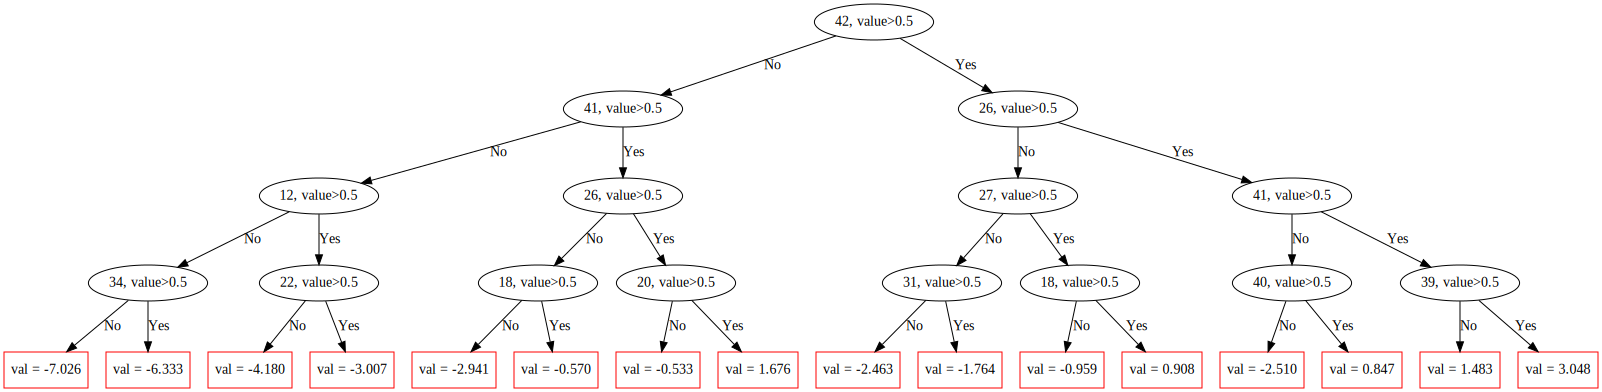

In [10]:
model.plot_tree(tree_idx = 0)

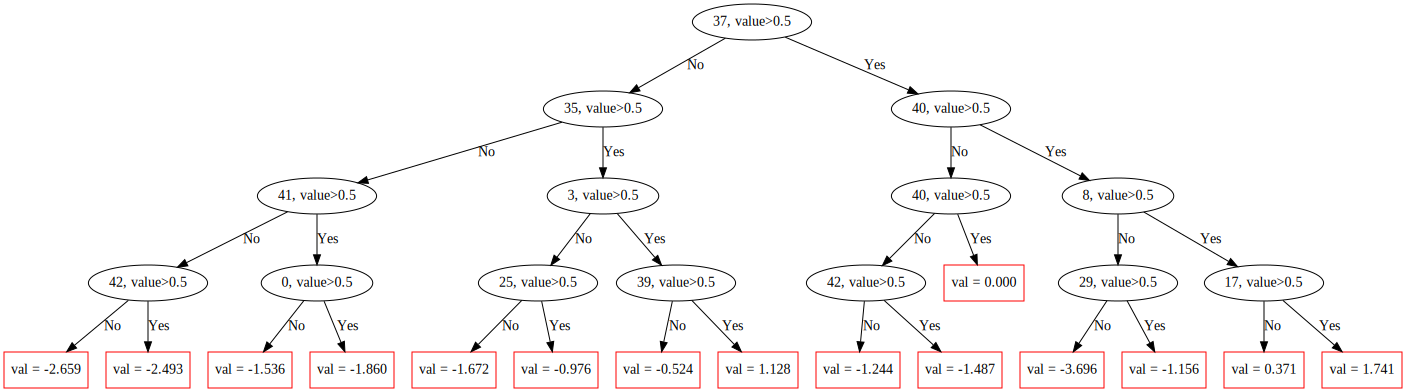

In [11]:
model.plot_tree(tree_idx = 1)

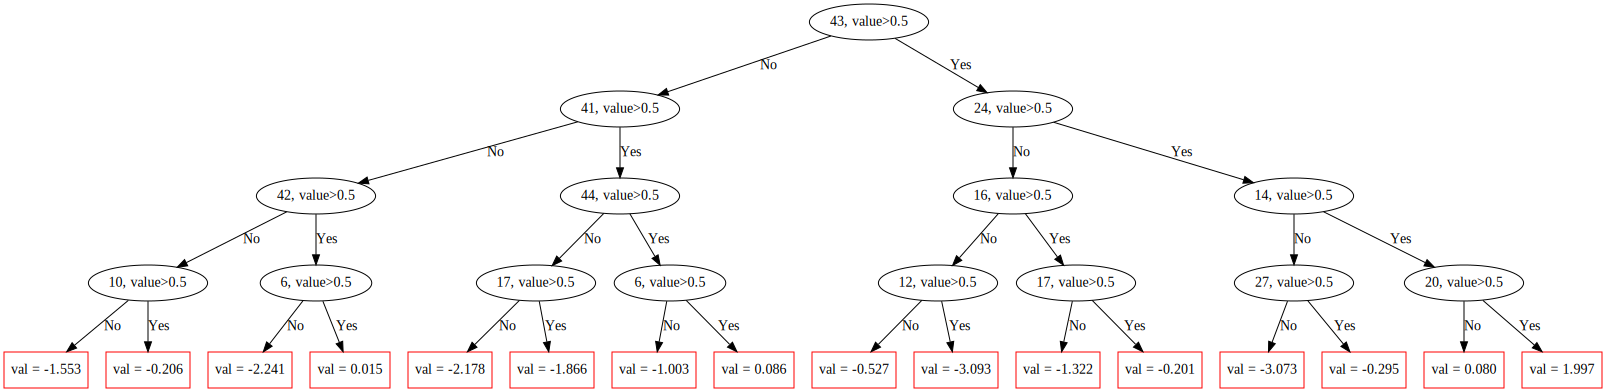

In [12]:
model.plot_tree(tree_idx = 2)